# PK Risk Estimation Walkthrough

This notebook demonstrates how the Monte Carlo simulations are constructed for estimating the PK re-identification risk of different policies when sharing patient-level disease surveillance data, such as that of COVID-19.

In [1]:
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data
First, the disease case counts data is loaded. This example is similar to the COVID-19 daily case counts data from the Johns Hopkins University (JHU) COVID-19 surveillance data repository. The data lists the number of new disease cases reported in a county (represented by a FIPS code) per day. This time series allows us to estimate the risk of sharing the updated dataset on a daily basis. For estimating the risk of sharing the updated dataset on a weekly basis, we convert the daily time series to a weekly time series.

In [2]:
# import disease case counts

df = pd.read_csv('example_counts_data.csv').set_index('fips')
df

,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10
fips,,,,,,,,,,,,,,,,,,,,,
1,0,1,6,6,7,9,1,13,9,15,...,60,48,45,20,40,46,2,2,7,23
2,0,3,1,4,7,9,13,11,10,4,...,64,28,25,24,25,34,32,37,35,15
3,0,2,2,4,7,4,10,8,14,2,...,32,36,25,59,53,14,11,29,42,20
4,1,1,3,2,3,8,4,3,2,3,...,39,48,47,35,46,26,15,32,35,32
5,1,1,1,6,0,6,5,0,11,18,...,59,29,50,17,37,35,34,3,8,30
6,1,2,2,6,1,3,1,11,8,9,...,22,5,28,18,34,56,10,22,48,42
7,0,0,3,2,5,10,3,8,2,12,...,10,48,51,42,25,31,20,34,31,19
8,1,1,2,0,7,6,4,14,6,10,...,54,41,39,27,50,22,11,15,25,9
9,0,0,1,3,4,3,3,13,9,2,...,13,44,10,60,15,46,43,27,31,16


Next, county demographic statistics are loaded. The example data, similar to that provided by the US Census PCT12 tables, lists the age, race, sex, and ethnicity joint statistics for each county. The data is formated in the following manner:

In [3]:
# import census data

census = pd.read_csv("example_census_data.csv")
census

,fips,age,race,sex,ethnicity,counts
0,1,0,w,Male,hl,8
1,1,1,w,Male,hl,6
2,1,2,w,Male,hl,7
3,1,3,w,Male,hl,6
4,1,4,w,Male,hl,9
...,...,...,...,...,...,...
28835,10,98,mixed,Female,nh,4
28836,10,99,mixed,Female,nh,3
28837,10,100,mixed,Female,nh,18
28838,10,105,mixed,Female,nh,0


# Code

The "generalize" helper function, defined below, generalizes and formats the census data according to the generalization scheme defined by a data sharing policy. An example output of the function is shown below. The example policy generalizes age to 15-year age bins and generalizes American Indian/Alaskan Native, Native Hawaiian/Pacific Islander, Mixed race, and Some Other race into a new Other race category.

In [4]:
def generalize(df, ind_col = "fips", ages = False, races = False, sexes = False, ethnicities = False):
    """
    Generalizes census data for age, race, sex, and/or ethnicity.
    """
    temp = df.copy()
    
    # generalize bin values
    if ages:
        temp['age'] = pd.cut(temp['age'],ages, right=False) 
    if races:
        for race_gen in races:
            for key, value in race_gen.items():
                for val in value:
                    temp.loc[temp.race == val, 'race'] = key          
    if sexes:
        temp['sex'] = 'both_sex'
    if ethnicities:
        temp['ethnicity'] = 'both_ethnicity'
        
    # groupby and sum values per demographic bin
    new_temp = temp.groupby([ind_col, 'sex', 'race', 'age', 'ethnicity'])\
                    .agg({'counts':'sum'})\
                    .astype({'counts':int})\
                    .reset_index()
    # label each bin
    new_temp['bins'] = new_temp['sex'] + \
                        ',' + new_temp['race'] + \
                        ',' + new_temp['ethnicity'] + \
                        ',' + new_temp['age']\
                        .astype(str)
    
    return new_temp.pivot_table(index = ind_col, columns = 'bins', values = 'counts')

# example
generalize(census,
           ages = [0, 15, 30, 45, 60, 75, 90, 120],
           races = [{'other':['ai_an', 'nh_pi', 'other', 'mixed']}]).head()

bins,"Female,a,hl,[0, 15)","Female,a,hl,[15, 30)","Female,a,hl,[30, 45)","Female,a,hl,[45, 60)","Female,a,hl,[60, 75)","Female,a,hl,[75, 90)","Female,a,hl,[90, 120)","Female,a,nh,[0, 15)","Female,a,nh,[15, 30)","Female,a,nh,[30, 45)",...,"Male,w,hl,[60, 75)","Male,w,hl,[75, 90)","Male,w,hl,[90, 120)","Male,w,nh,[0, 15)","Male,w,nh,[15, 30)","Male,w,nh,[30, 45)","Male,w,nh,[45, 60)","Male,w,nh,[60, 75)","Male,w,nh,[75, 90)","Male,w,nh,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1313,1125,1135,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1228,1156,1089,1226,1248,1307,1081,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, we define the privacy_risk_estimation_PK class. This class is used to run multiple Monte Carlo random sampling simulations to estimate the PK risk. The sampling is performed without replacement (dependent sampling). The PK risk is estimated on the most recent records shared according to a user-specified lagging period.

In [5]:
class privacy_risk_estimation_PK:
    
    """
    Uses Monte Carlo sampling techniques (without replacement) to estimate the longitudinal PK risk
    of a sharing patient-level pandemic data on a consistent basis (e.g., daily or weekly)
    for a user-specified k value. The PK risk is estimated for each time point in a given county,
    when sharing data under a specific data sharing policy (which defines the demographic bins). 
    The PK risk values are calculated on a lagged period of infected individuals.
    
    Input:
    counts = Dataframe of the case counts per time period (e.g. daily counts of new disease cases from
             the JHU COVID-19 surveillance data). Must include the fips code in the index and the columns
             must be date values.
    gen_census = The generalized census, i.e., the output of the generalize function above for the
                 specified fips code.
    fips = The fips code of interest. Must be of the same format of the counts dataframe index column.
    n_sims = The number of simulations to be run in the experiment.
    k = The k value to be used in the PK risk calculation. Default is 10.
    period_size = The size of the lagging period to be used for calculating the PK risk values.
                  Default value is 3.
    
    Output:
    self.PK = Dataframe where each row is a unique simulation and each column is a time period. Each cell
              value corresponds to the proportion of infected individuals who fall into a demographic
              bins of size k or less. The self.PK values are calculated from a lagged period of
              individuals, whose size is specified by period_size. For example, if period_size = 3 and
              the dataset is updated daily, the PK risk value on a given day in a given simulation is 
              the proportion of infected individuals from the day and the previous two days who fall into a 
              demographic bins of size k or less.
    """
    
    def __init__(self, counts, gen_census, fips, n_sims, k=10, period_size=3, rng=np.random.default_rng()):
        
        self.counts = counts.loc[fips,:].values
        self.dates = counts.columns
        self.census = gen_census
        self.n_bins = len(self.census)
        self.PK = pd.DataFrame(columns = self.dates)
        self.n_sims = n_sims
        self.xk = np.arange(self.n_sims)
        self.k = k
        self.period_size = period_size
        self.recent_cases = []
        self.rng = rng
        
    def create_full_population(self):
        
        """
        Creates full population from generalized census counts.
        """
        
        self.full_pop = np.tile(self.census.values, (self.n_sims,1))
        
    def get_infected_population(self):
        
        """
        Creates the infected population for each simulation.
        """
        
        ppl = self.full_pop[0]
        self.indexed_pop = np.concatenate(list(map(lambda i: np.repeat(i, ppl[i]), range(len(ppl)))),axis=0)
        
        # if more than one equivalence class, randomly choose infected from full population
        if len(self.full_pop[0]) > 1:
            self.choose_infected()
        else:
            self.choose_infected(False)
        
    def choose_infected(self, true_shuffle=True):
        
        """
        Monte Carlo random samples without replacement the infected indviduals from the population.
        """
        
        total_ppl = self.counts.sum()
        
        if true_shuffle:
            self.infected = np.stack(list(map(lambda sim: self.rng.choice(self.indexed_pop,
                                                                          size=total_ppl,
                                                                          replace=False),
                                         range(self.n_sims))), axis=0)
        else:
            row = self.indexed_pop[:total_ppl]
            self.infected = np.tile(row, (self.n_sims, 1))
            
        #del self.indexed_pop
    
    def count_per_bin(self):
            
        """
        Counts the number of infected individuals in each demographic bin for the current time
        period's infections.
        """
        
        # empty array for the time period's newest per bin per simulation
        self.new_cases = np.zeros((self.n_sims, self.n_bins))
        
        # split shuffled values on sample size
        samples, self.infected = np.split(self.infected, [self.n_ppl], axis=1)
        
        # add infected people per bin
        for i in samples.T:
            self.new_cases[self.xk,i] += 1
    
    def drop_frame(self):
        
        """
        Removes the oldest set of infections from recent cases.
        """
        
        self.recent_cases.pop(0)
        
    def add_frame(self):
        
        """
        Adds the newest set of infections to recent cases.
        """
        
        self.recent_cases.append(self.new_cases)
    
    def update_recent_cases(self):
        
        """
        Updates the list of recent cases reported within the lagging period.
        """
        
        if len(self.recent_cases) == self.period_size:
            self.drop_frame()
            self.add_frame()
        else:
            self.add_frame()
        self.get_cases_in_period()
        
    def get_cases_in_period(self):
        
        """
        Sums the number of reported cases in each demographic bin with a diagnosis date within
        the lagging period.
        """
        
        self.cases_in_period = sum(self.recent_cases)
    
    def calc_PK_risk(self):
        
        """
        Calculates the PK risk on the cases reported in the lagging period.
        """
        
        n_ppl = self.cases_in_period.sum(axis=1)[0]
        if n_ppl == 0:
            return [0] * self.n_sims
        else:
            risk = np.ndarray((self.n_sims, self.k))
            for i in range(1, self.k+1):
                risk[:,(i-1)] = np.count_nonzero(self.cases_in_period == i, axis=1) * i
            return risk.sum(axis=1)/n_ppl
        
    def run_full_simulation(self):
        """
        Runs the full simulation.
        """
        self.create_full_population()
        self.get_infected_population()
        
        fill_zeros = True
        
        for i in range(len(self.dates)):
            date = self.dates[i]
            self.n_ppl = self.counts[i]
            
            if fill_zeros:
                if (self.n_ppl == 0):
                    self.PK[date] = [0] * self.n_sims
                else:
                    self.count_per_bin()
                    self.update_recent_cases()
                    self.PK[date] = self.calc_PK_risk()
                    fill_zeros = False
                
            else:
                self.count_per_bin()
                self.update_recent_cases()
                self.PK[date] = self.calc_PK_risk()
        
    def get_stats(self, df, percentiles):
        
        """
        Helper function to generate summary statistics on the simulation results.
        """
        
        stats = np.percentile(df, percentiles, axis=0)
        results = pd.DataFrame()
        results['date'] = self.dates
        results['lower'] = stats[0, :]
        results['mean'] = np.mean(df, axis=0).values
        results['upper'] = stats[1, :]

        return results

# Simulation details
## Simulating who gets infected

First, we demonstrate how the Monte Carlo simulation selects who gets infected in a county. Using the generalize function, the population joint statistics are generalized into four bins: female <50 years old, females >= 50 years old, males < 50 years old, and males >= 50 years old.

In [6]:
gc = generalize(census,
                ages = [0, 50, 120],
                races = [{'all_race':['w', 'b', 'ai_an', 'a', 'nh_pi', 'other', 'mixed']}],
                sexes = False,
                ethnicities = True)

gc

bins,"Female,all_race,both_ethnicity,[0, 50)","Female,all_race,both_ethnicity,[50, 120)","Male,all_race,both_ethnicity,[0, 50)","Male,all_race,both_ethnicity,[50, 120)"
fips,,,,
1,5923,6085,6314,6122
2,5430,6221,5584,5876
3,5581,6102,5498,5975
4,5434,5804,6044,5567
5,5941,5662,5701,5992
6,16686,14676,20121,15127
7,6207,6603,6517,6255
8,5495,6024,5703,5636
9,5635,6188,5675,5794


In this example, we run 5 simulations for the example county with FIPS code 1. We define a lagging period of 3 days. The generalized census data for FIPS 1 is shown above. According to the example census data, FIPS 1 5,923 females younger than 50 years old; 6,085 females 50 years and older; 6,314 males less than 50 years old; and 6,122 males 50 years and older. 

After initializing the class object, the full_pop array is created. The full_pop array keeps the numbers of full population separated by demographic group according to the policy for each simulation. In this case, the array is of size 5x4; i.e., 5 simulations and 4 demographic groups in the policy.

In [7]:
# choose county
fip = 1

# initialize class object
mc = privacy_risk_estimation_PK(counts = df.loc[fip,:].to_frame().transpose(),
                                gen_census = gc.loc[fip,:],
                                fips = fip,
                                n_sims = 5,
                                k = 10, # k=10 for PK10 estimates
                                period_size = 3,
                                rng = np.random.default_rng(0)) # seeded for reproducibility

# create full population for each simulation
mc.create_full_population()
mc.full_pop

array([[5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122]])

Next the class an indexed population array, from which the infected individuals will be randomly sampled. Within the indexed population array, each individual is represented by the index value of their demographic group - the 5,923 females younger than 50 are represented with the value 0; the 6,085 females 50 and older are represented with the value 1; etc.

In [8]:
# create indexed population
mc.get_infected_population()

# show how many 0, 1, 2, and 3 index values are in each row.
print(pd.Series(mc.indexed_pop).value_counts())

2    6314
3    6122
1    6085
0    5923
dtype: int64


From the indexed population array, we independently sample x individuals for each simulation, where x is the total number of disease cases reported per the timeseries data. In this county, the time series contains 2,873 total reported cases. The results of each simulation are stacked into a single array. In this case, we are running five simulations, so the infected individuals array has five rows. This infected array holds all the individuals who are randomly infected throughout the time series for each simulation. The ordering of these individuals in the row will determine the order by which the individuals are reported as disease cases in the time series and are represented in the simulated dataset.

In [9]:
print("Infected array shape:", mc.infected.shape)

mc.infected

Infected array shape: (5, 2873)


array([[1, 2, 0, ..., 2, 2, 3],
       [2, 0, 3, ..., 0, 3, 3],
       [1, 2, 2, ..., 3, 1, 3],
       [3, 2, 3, ..., 3, 3, 3],
       [0, 1, 0, ..., 0, 3, 1]])

Now that we have the randomly infected population for each simulation, we can simulate when each individual is reported as a disease case. How many cases per time period is normally defined by the input time series data, but in this reduced example, we will say 1 case was reported on the first day. The simulation takes the first index value from each row of the infected array and adds it to the same row of the new_cases array. The new_cases array is the same size as the full_pop array (5x4) and holds the counts of how many disease cases are reported per demographic bin per simulation on the specific time period.

In [10]:
# single time period with 1 case
mc.n_ppl = 1
mc.count_per_bin()
mc.update_recent_cases()

print('new_cases:')
print(mc.new_cases)

new_cases:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


The first individual from the top row (or top simulation) of the infected array to get sick has index value 1. That results in one individual in the 1-index (moving from left to right) bin in the first row of the new_cases array. The counts for each cell on the other rows are counted similarly.

When individuals are infected and reported as a disease case, they are removed from the infected array and added to the new_cases array. Notice how the number of columns in the infected array has now reduced by 1:

In [11]:
print("New infected array shape:", mc.infected.shape)

New infected array shape: (5, 2872)


In addition to the new_cases array, the class object holds a list (recent_cases) of the new_cases arrays from the current time period and the previous time periods according to the size of the lagging period. The cases_in_period array is the cell-wise sum of the arrays held in the recent_cases list. Its format is identical to the new_cases array. On the first time period, both new_cases and cases_in_period should have the same values.

In [12]:
print('cases_in_period:')
print(mc.cases_in_period)


cases_in_period:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


We continue the simulation to the next time period, which we will say has fifteen cases. Notice how the cases_in_period array now has different values than the new_cases array.

In [13]:
# second day with 15 cases
print("Infected array shape before removing 15 more cases:", mc.infected.shape)
print()

mc.n_ppl = 15
mc.count_per_bin()
mc.update_recent_cases()

print("Infected array shape after 15 more cases:", mc.infected.shape)
print()
print('new_cases:')
print(mc.new_cases)
print()
print('cases_in_period:')
print(mc.cases_in_period)

Infected array shape before removing 15 more cases: (5, 2872)

Infected array shape after 15 more cases: (5, 2857)

new_cases:
[[5. 4. 4. 2.]
 [3. 4. 3. 5.]
 [4. 3. 6. 2.]
 [5. 3. 3. 4.]
 [1. 4. 5. 5.]]

cases_in_period:
[[5. 5. 4. 2.]
 [3. 4. 4. 5.]
 [4. 4. 6. 2.]
 [5. 3. 3. 5.]
 [2. 4. 5. 5.]]


We now simulate 3 more time periods, with 10, 5, and 12 cases, respectively. Notice how, on this list time period, the new_cases array only has one person in each row, and the cases_in_period array has 27 people in each row (the counts from the most recent 3 days).

In [14]:
# 3 more days
mc.n_ppl = 10
mc.count_per_bin()
mc.update_recent_cases()
mc.n_ppl = 5
mc.count_per_bin()
mc.update_recent_cases()
mc.n_ppl = 12
mc.count_per_bin()
mc.update_recent_cases()

print("New infected array shape:", mc.infected.shape)
print()
print('new_cases:')
print(mc.new_cases)
print()
print('cases_in_period:')
print(mc.cases_in_period)

New infected array shape: (5, 2830)

new_cases:
[[1. 4. 4. 3.]
 [3. 4. 3. 2.]
 [6. 2. 3. 1.]
 [1. 4. 3. 4.]
 [4. 2. 1. 5.]]

cases_in_period:
[[ 3.  6. 11.  7.]
 [ 7.  6.  9.  5.]
 [10.  4.  9.  4.]
 [ 5.  8.  7.  7.]
 [ 9.  5.  5.  8.]]


## PK risk calculation

Finally, we show how the PK risk is calculated when k=10. The PK risk is calculated on each time period and within each simulatoin using the cases_in_period array. This measures the proportion of infected individuals in the simulated dataset who fall into a demographic group of size k or smaller, under the relaxed assumption that the attacker only knows the window (of 3 days in this case) in which the target was diagnosed.

In [15]:
print('cases_in_period:')
print(mc.cases_in_period)
print()
print('pk risk for each simulation:')
print(mc.calc_PK_risk())
print()
print('Expected risk =', np.mean(mc.calc_PK_risk()))

cases_in_period:
[[ 3.  6. 11.  7.]
 [ 7.  6.  9.  5.]
 [10.  4.  9.  4.]
 [ 5.  8.  7.  7.]
 [ 9.  5.  5.  8.]]

pk risk for each simulation:
[0.59259259 1.         1.         1.         1.        ]

Expected risk = 0.9185185185185185


In only the top row simulation is there a demographic group with more than 10 individuals. Therefore the PK10 for the first simulated dataset is lowere than that of the other four. The expected pk risk value, for this county and policy and for this time period, is about 0.92.

# Full simulation example
To finish this walkthrough, we give a full example using our example data. In this example, the policy generalizes age into 15-yeare age bins [0-15), [15-30), [30-45), [45-60), [60-75), [75-90), and 90+. Sex and ethnicity are suppressed. Race is not generalized nor suppressed. This results in 49 potential demographic bins in each county, according to the policy.

In [16]:
gc = generalize(census,
                ages = [0, 15, 30, 45, 60, 75, 90, 120],
                sexes = True,
                ethnicities = True)

gc

bins,"both_sex,a,both_ethnicity,[0, 15)","both_sex,a,both_ethnicity,[15, 30)","both_sex,a,both_ethnicity,[30, 45)","both_sex,a,both_ethnicity,[45, 60)","both_sex,a,both_ethnicity,[60, 75)","both_sex,a,both_ethnicity,[75, 90)","both_sex,a,both_ethnicity,[90, 120)","both_sex,ai_an,both_ethnicity,[0, 15)","both_sex,ai_an,both_ethnicity,[15, 30)","both_sex,ai_an,both_ethnicity,[30, 45)",...,"both_sex,other,both_ethnicity,[60, 75)","both_sex,other,both_ethnicity,[75, 90)","both_sex,other,both_ethnicity,[90, 120)","both_sex,w,both_ethnicity,[0, 15)","both_sex,w,both_ethnicity,[15, 30)","both_sex,w,both_ethnicity,[30, 45)","both_sex,w,both_ethnicity,[45, 60)","both_sex,w,both_ethnicity,[60, 75)","both_sex,w,both_ethnicity,[75, 90)","both_sex,w,both_ethnicity,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2464,3014,2619,2492,2591,2375,2176
2,0,0,0,0,0,0,0,1780,1918,1946,...,0,0,0,0,0,0,0,0,0,0
3,2407,2340,2210,2387,2478,2457,2111,531,510,506,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1429,1448,1269,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1001,994,806,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8854,10968,9191,13841,10036,4899,2063
7,0,0,0,0,0,0,0,1968,1900,2074,...,0,0,0,0,0,0,0,0,0,0
8,2402,2258,2301,2360,2374,2339,2110,519,632,556,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1367,1375,1425,0,0,0,0,0,0,0


The simulation will uses the example data to define the disease record counts per day, estimating the risk for daily updating the surveillance dataset to be shared. We define a lagging period of three days and run 1,000 simulations. To summarize each simulation's risk values, we will take the mean and 95% quantile range each day's set of risk values.

In [17]:
%%time

# set parameters
fip = 1
wind_size = 3

# initialize object
mc = privacy_risk_estimation_PK(counts = df.loc[fip,:].to_frame().transpose(),
                    gen_census = gc.loc[fip,:],
                    fips = fip,
                    n_sims = 1000,
                    k = 10,
                    period_size = wind_size)

# run simulation
mc.run_full_simulation()

# summarize results
PK10 = mc.get_stats(mc.PK, [2.5, 97.5]).fillna(0)

CPU times: user 284 ms, sys: 17 ms, total: 301 ms
Wall time: 299 ms


In [18]:
PK10

,date,lower,mean,upper
0,2020-01-01,0.000000,0.000000,0.000000
1,2020-01-02,1.000000,1.000000,1.000000
2,2020-01-03,1.000000,1.000000,1.000000
3,2020-01-04,1.000000,1.000000,1.000000
4,2020-01-05,1.000000,1.000000,1.000000
...,...,...,...,...
96,2020-04-06,0.311085,0.524434,0.745519
97,2020-04-07,0.454545,0.696034,0.875000
98,2020-04-08,0.760000,0.979240,1.000000
99,2020-04-09,1.000000,1.000000,1.000000


Text(0.5, 0, 'Date')

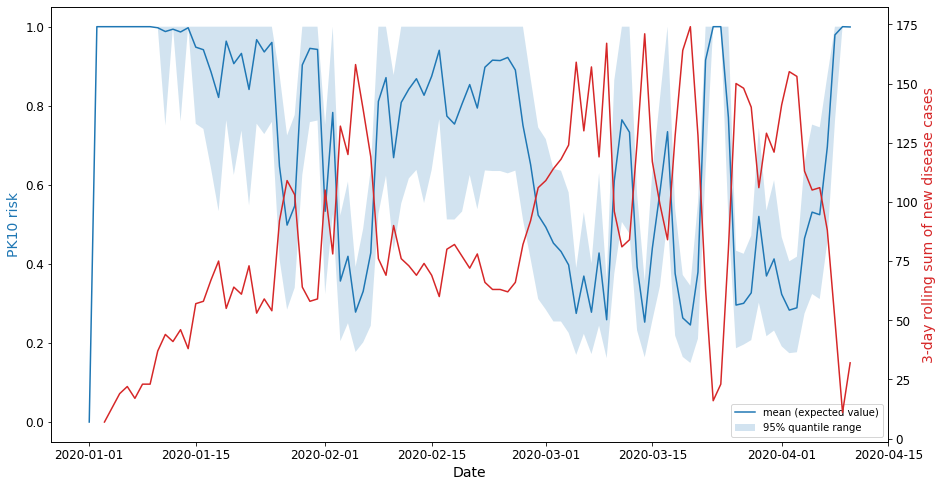

In [19]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(15,8), sharex=True)

cases = df.loc[fip,:]
cases.index = pd.to_datetime(cases.index)

# PK risk
ax.plot(pd.to_datetime(PK10['date']),
           PK10['mean'].values,
           label='mean (expected value)')
ax.fill_between(pd.to_datetime(PK10['date']),
                   PK10['lower'].values,
                   PK10['upper'].values,
                   alpha=0.2, label='95% quantile range')

ax2 = ax.twinx()
ax2.plot(pd.to_datetime(PK10['date']),
         cases.rolling(3, closed='right').sum().values,
         color='tab:red')

ax.legend(loc='best')

ax.set_ylabel('PK10 risk',
                 color='tab:blue', fontsize=14)
ax2.set_ylabel(str(wind_size) + '-day rolling sum of new disease cases', color='tab:red', fontsize=14)

ax.tick_params(labelsize='large')
ax2.tick_params(labelsize='large')

ax.set_xlabel('Date', fontsize=14)

We see that the estimated PK10 risk is inversely proportional to the number of new disease cases. Thus, the policy's privacy protection fluctuates with the number of new records.